In [1]:
!pip install segmentation-models-pytorch

  Obtaining dependency information for segmentation-models-pytorch from https://files.pythonhosted.org/packages/54/dd/0a3417eebc791d1f60ba9949a2c6fcb406ba671c67042179fb270409b17b/segmentation_models_pytorch-0.3.4-py3-none-any.whl.metadata
  Preparing metadata (setup.py) ... - done
  Obtaining dependency information for huggingface-hub>=0.24.6 from https://files.pythonhosted.org/packages/d5/ce/1f8e61cd63175cc2e79233b954b1c4e85363c788fb3a1fa23c87a25c9b81/huggingface_hub-0.25.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Obtaining dependency information for timm==0.9.7 from https://files.pythonhosted.org/packages/7a/bd/2c56be7a3b5bc71cf85a405246b89d5359f942c9f7fb6db6306d9d056092/timm-0.9.7-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.4 MB/s eta 0:00:00
  Obtaining dependency information for munch from https://files.pythonhosted.org/pa

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import os
import cv2

from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from torchvision.io import read_image
from PIL import Image
from torch.utils.tensorboard import SummaryWriter

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Define path variables
TRAIN_DATA_PATH = '/kaggle/working/'
DATA_DIR = '/kaggle/working'

# Select the device to train on
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
EPOCHS = 100        # number of epochs
LR = 0.0001         # Learning rate
IMG_SIZE = 256     # Size of image
BATCH_SIZE = 8    # Batch size 
writer=SummaryWriter("Noisy_Dataset")

In [4]:
images=os.listdir("/kaggle/input/nr206-oct-dataset/NR206/train")
masks=os.listdir("/kaggle/input/nr206-oct-dataset/NR206/train_labels")
train_df=pd.DataFrame({"images":map(lambda x:os.path.join("/kaggle/input/nr206-oct-dataset/NR206/train",x),images),"masks":map(lambda x:os.path.join("/kaggle/input/nr206-oct-dataset/NR206/train_labels",x),masks)})
print(train_df.shape)
train_df.head()
del images, masks

(126, 2)


In [5]:
images=os.listdir("/kaggle/input/nr206-oct-dataset/NR206/val")
masks=os.listdir("/kaggle/input/nr206-oct-dataset/NR206/val_labels")
val_df=pd.DataFrame({"images":map(lambda x:os.path.join("/kaggle/input/nr206-oct-dataset/NR206/val",x),images),"masks":map(lambda x:os.path.join("/kaggle/input/nr206-oct-dataset/NR206/val_labels",x),masks)})
print(val_df.shape)
val_df.head()
del images, masks

(40, 2)


In [6]:
images=os.listdir("/kaggle/input/nr206-oct-dataset/NR206/test")
masks=os.listdir("/kaggle/input/nr206-oct-dataset/NR206/test_labels")
test_df=pd.DataFrame({"images":map(lambda x:os.path.join("/kaggle/input/nr206-oct-dataset/NR206/test",x),images),"masks":map(lambda x:os.path.join("/kaggle/input/nr206-oct-dataset/NR206/test_labels",x),masks)})
print(test_df.shape)
test_df.head()
del images, masks

(40, 2)


In [7]:
sample = val_df.iloc[np.random.randint(0, val_df.shape[0], size=5)]

def generate_sample_images(sample):
    imgs = sample.images

    _, ax = plt.subplots(1, 5, figsize=(15,3))
    ax = ax.flatten()

    for i, image in enumerate(imgs):
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ax[i].set_title("IMAGE")
        ax[i].imshow(image)

def generate_sample_masks(sample):
    masks = sample.masks

    _, ax = plt.subplots(1, 5, figsize=(15,3))
    ax = ax.flatten()

    for i, mask in enumerate(masks):
        mask = cv2.imread(mask)

        ax[i].set_title("GROUND TRUTH")
        ax[i].imshow(mask, cmap='gray')

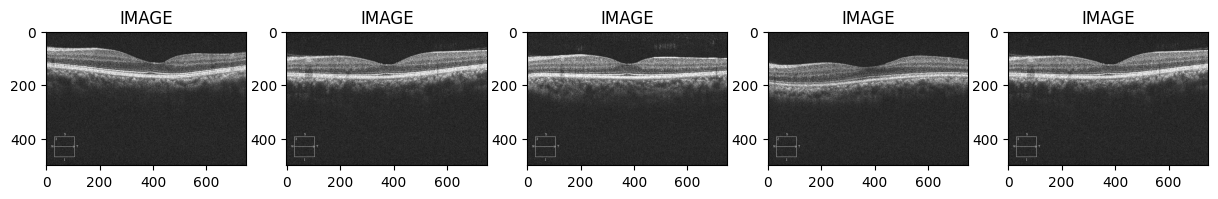

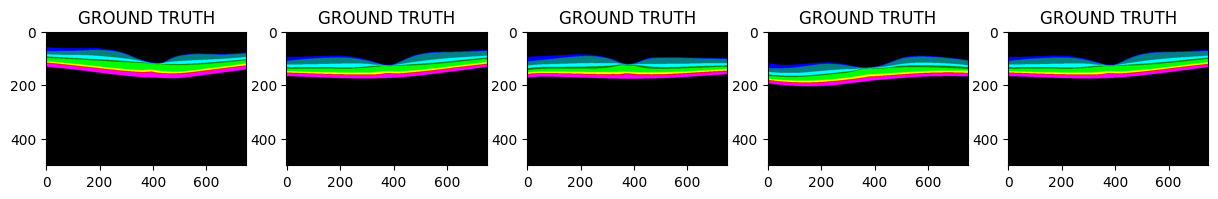

In [8]:
generate_sample_images(sample)
generate_sample_masks(sample)

In [9]:
import albumentations as A

In [10]:
# Define the augmentations
def get_train_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=0.5),      # Horizontal Flip with 0.5 probability
        A.VerticalFlip(p=0.5)         # Vertical Flip with 0.5 probability
    ], is_check_shapes=False)

def get_val_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE)
    ], is_check_shapes=False)

In [11]:
from torch.utils.data import Dataset

In [12]:
# Create a custom dataset class
class SegmentationDataset(Dataset):
    def __init__(self, df, augs):
        self.df = df
        self.augs = augs

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        image = sample.images
        mask = sample.masks
        
        # Read images and masks
        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask)
        
        # print(f"Shapes of images before augmentation: {image.shape}")
        # print(f"Shapes of masks before augmentation: {mask.shape}")
        
        # Apply augmentations
        if self.augs:
            data = self.augs(image=image, mask=mask)
            image = data['image']
            mask = data['mask']
            
        # print(f"\nShapes of images after augmentation: {image.shape}")
        # print(f"Shapes of masks after augmentation: {mask.shape}")
        
        # Transpose image dimensions in pytorch format
        # (H,W,C) -> (C,H,W)
        image = image.astype(np.float32)
        mask = np.transpose(mask, (2,0,1)).astype(np.float32)
        
        # Normalize the images and masks
        image = (torch.Tensor(image)/255.0).unsqueeze(0)
        mask = torch.Tensor(mask)/255.0

        return image, mask

In [13]:
# Processed train and validation sets
train_data = SegmentationDataset(train_df, get_train_augs())
val_data = SegmentationDataset(val_df, get_val_augs())

In [14]:
print(f"Size of Trainset : {len(train_data)}")
print(f"Size of Validset : {len(val_data)}")

Size of Trainset : 126
Size of Validset : 40


In [15]:
from torch.utils.data import DataLoader

In [16]:
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

print(f"Total number of batches in Train Loader: {len(trainloader)}")
print(f"Total number of batches in Val Loader: {len(valloader)}")

Total number of batches in Train Loader: 16
Total number of batches in Val Loader: 5


In [17]:
for image, mask in trainloader:
    print(f"Size of one batch of images: {image.shape}")
    print(f"Size of one batch of masks: {mask.shape}")
    break

Size of one batch of images: torch.Size([8, 1, 256, 256])
Size of one batch of masks: torch.Size([8, 3, 256, 256])


In [18]:
import torch.nn as nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [19]:
def dice_score(y_true, y_pred):
    return 1.0-DiceLoss(mode="binary")(y_true, y_pred)
            
def jac_score(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    return (intersection + 1e-15) / (union + 1e-15) 

In [20]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()
        self.model = smp.Unet(
            in_channels=1,
            classes=3,
            activation=None)

    def forward(self, images, masks=None):
        logits = self.model(images)
        if masks != None:
            loss = DiceLoss(mode='binary')(logits, masks)
            score = dice_score(logits, masks)
            return logits, loss, score
        return logits

In [21]:
# model = nn.DataParallel(SegmentationModel())
model = SegmentationModel()
model.to(DEVICE);

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 211MB/s]


In [22]:
# Function to train the model
def train_model(data_loader, model, optimizer):
    total_loss = 0.0
    total_score = 0.0
    model.train()

    for images, masks in tqdm(data_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        
        optimizer.zero_grad()
        logits, loss, score = model(images, masks)
        loss.backward()
        optimizer.step()
        total_score += score.item()
        total_loss += loss.item()

    return total_loss / len(data_loader), total_score / len(data_loader)

In [23]:
# Function to evaluate the model
def eval_model(data_loader, model):
    total_loss = 0.0
    total_score = 0.0
    model.eval()

    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            logits, loss, score = model(images, masks)

            total_score += score.item()
            total_loss += loss.item()

        return total_loss / len(data_loader), total_score / len(data_loader)

In [24]:
# Define the optimizer 
optimizer = torch.optim.RMSprop(model.parameters(), lr=LR)

In [25]:
# Training and evaluation loop
best_val_loss = 1e9

for i in range(EPOCHS):
    train_loss, train_score = train_model(trainloader, model, optimizer)
    val_loss, val_score = eval_model(valloader, model)

    if val_loss < best_val_loss:
        # Save the best model
        torch.save(model.state_dict(), 'best_Noisy_model_SD.pt')
        torch.save(model, 'best_Noisy_model.pt')
        print("MODEL SAVED")
        
        best_val_loss = val_loss
    writer.add_scalar("Loss/train", train_loss, i)
    writer.add_scalar("Loss/val", val_loss, i)
    writer.add_scalar("Score/train", train_score, i)
    writer.add_scalar("Score/val", val_score, i)
    writer.flush()
    print(f"\033[1m\033[92m Epoch {i+1} Train DiceLoss {train_loss} Val DiceLoss {val_loss} Train DiceScore {train_score} Val DiceScore {val_score}")
writer.close()

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 1 Train DiceLoss 0.8043793514370918 Val DiceLoss 0.8065446853637696 Train DiceScore 0.19562064856290817 Val DiceScore 0.19345531463623047


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 2 Train DiceLoss 0.7333805598318577 Val DiceLoss 0.7271366238594055 Train DiceScore 0.2666194401681423 Val DiceScore 0.27286337614059447


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 3 Train DiceLoss 0.6967069506645203 Val DiceLoss 0.6804974555969239 Train DiceScore 0.30329304933547974 Val DiceScore 0.3195025444030762


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 4 Train DiceLoss 0.665598526597023 Val DiceLoss 0.6447453379631043 Train DiceScore 0.334401473402977 Val DiceScore 0.35525466203689576


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 5 Train DiceLoss 0.6346455514431 Val DiceLoss 0.6078901648521423 Train DiceScore 0.3653544485569 Val DiceScore 0.3921098351478577


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 6 Train DiceLoss 0.6046651229262352 Val DiceLoss 0.5863260269165039 Train DiceScore 0.3953348770737648 Val DiceScore 0.41367397308349607


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 7 Train DiceLoss 0.575879842042923 Val DiceLoss 0.5554973959922791 Train DiceScore 0.424120157957077 Val DiceScore 0.44450260400772096


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 8 Train DiceLoss 0.546561636030674 Val DiceLoss 0.5251248478889465 Train DiceScore 0.453438363969326 Val DiceScore 0.47487515211105347


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 9 Train DiceLoss 0.5210870206356049 Val DiceLoss 0.504841434955597 Train DiceScore 0.47891297936439514 Val DiceScore 0.4951585650444031


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 10 Train DiceLoss 0.49519074708223343 Val DiceLoss 0.47859945297241213 Train DiceScore 0.5048092529177666 Val DiceScore 0.5214005470275879


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 11 Train DiceLoss 0.46921782195568085 Val DiceLoss 0.4485164523124695 Train DiceScore 0.5307821780443192 Val DiceScore 0.5514835476875305


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 12 Train DiceLoss 0.4459707513451576 Val DiceLoss 0.4275071382522583 Train DiceScore 0.5540292486548424 Val DiceScore 0.5724928617477417


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 Epoch 13 Train DiceLoss 0.42737967893481255 Val DiceLoss 0.4917906761169434 Train DiceScore 0.5726203210651875 Val DiceScore 0.5082093238830566


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 14 Train DiceLoss 0.4166194275021553 Val DiceLoss 0.38972299098968505 Train DiceScore 0.5833805724978447 Val DiceScore 0.6102770090103149


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 15 Train DiceLoss 0.3849691264331341 Val DiceLoss 0.37056884765625 Train DiceScore 0.6150308735668659 Val DiceScore 0.62943115234375


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 16 Train DiceLoss 0.3670995607972145 Val DiceLoss 0.35300842523574827 Train DiceScore 0.6329004392027855 Val DiceScore 0.6469915747642517


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 17 Train DiceLoss 0.35244467481970787 Val DiceLoss 0.3386582136154175 Train DiceScore 0.6475553251802921 Val DiceScore 0.6613417863845825


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 18 Train DiceLoss 0.33630596473813057 Val DiceLoss 0.3231687068939209 Train DiceScore 0.6636940352618694 Val DiceScore 0.6768312931060791


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 19 Train DiceLoss 0.3209041617810726 Val DiceLoss 0.3081307649612427 Train DiceScore 0.6790958382189274 Val DiceScore 0.6918692350387573


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 20 Train DiceLoss 0.308532290160656 Val DiceLoss 0.2993252992630005 Train DiceScore 0.691467709839344 Val DiceScore 0.7006747007369996


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 21 Train DiceLoss 0.29559701308608055 Val DiceLoss 0.2826067566871643 Train DiceScore 0.7044029869139194 Val DiceScore 0.7173932433128357


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 22 Train DiceLoss 0.2833143249154091 Val DiceLoss 0.2729661226272583 Train DiceScore 0.7166856750845909 Val DiceScore 0.7270338773727417


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 23 Train DiceLoss 0.2735070288181305 Val DiceLoss 0.263123881816864 Train DiceScore 0.7264929711818695 Val DiceScore 0.736876118183136


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 24 Train DiceLoss 0.2629096396267414 Val DiceLoss 0.25196712017059325 Train DiceScore 0.7370903603732586 Val DiceScore 0.7480328798294067


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 25 Train DiceLoss 0.25421150401234627 Val DiceLoss 0.24243417978286744 Train DiceScore 0.7457884959876537 Val DiceScore 0.7575658202171326


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 26 Train DiceLoss 0.24483370035886765 Val DiceLoss 0.2329424023628235 Train DiceScore 0.7551662996411324 Val DiceScore 0.7670575976371765


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 27 Train DiceLoss 0.23723968490958214 Val DiceLoss 0.22723175287246705 Train DiceScore 0.7627603150904179 Val DiceScore 0.772768247127533


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 28 Train DiceLoss 0.22947992011904716 Val DiceLoss 0.22288126945495607 Train DiceScore 0.7705200798809528 Val DiceScore 0.777118730545044


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 29 Train DiceLoss 0.22382492572069168 Val DiceLoss 0.21516233682632446 Train DiceScore 0.7761750742793083 Val DiceScore 0.7848376631736755


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 30 Train DiceLoss 0.21602074801921844 Val DiceLoss 0.206953763961792 Train DiceScore 0.7839792519807816 Val DiceScore 0.793046236038208


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 Epoch 31 Train DiceLoss 0.2102549448609352 Val DiceLoss 0.21513792276382446 Train DiceScore 0.7897450551390648 Val DiceScore 0.7848620772361755


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 32 Train DiceLoss 0.2041473723948002 Val DiceLoss 0.19501228332519532 Train DiceScore 0.7958526276051998 Val DiceScore 0.8049877166748047


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 33 Train DiceLoss 0.1981061026453972 Val DiceLoss 0.1930304765701294 Train DiceScore 0.8018938973546028 Val DiceScore 0.8069695234298706


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 34 Train DiceLoss 0.19392439723014832 Val DiceLoss 0.18660818338394164 Train DiceScore 0.8060756027698517 Val DiceScore 0.8133918166160583


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 35 Train DiceLoss 0.1896843984723091 Val DiceLoss 0.18480781316757203 Train DiceScore 0.8103156015276909 Val DiceScore 0.815192186832428


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 36 Train DiceLoss 0.1848810315132141 Val DiceLoss 0.1776239514350891 Train DiceScore 0.8151189684867859 Val DiceScore 0.8223760485649109


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 37 Train DiceLoss 0.18084900826215744 Val DiceLoss 0.17450069189071654 Train DiceScore 0.8191509917378426 Val DiceScore 0.8254993081092834


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 38 Train DiceLoss 0.17791790515184402 Val DiceLoss 0.16963037252426147 Train DiceScore 0.822082094848156 Val DiceScore 0.8303696274757385


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 39 Train DiceLoss 0.1738499142229557 Val DiceLoss 0.16637519598007203 Train DiceScore 0.8261500857770443 Val DiceScore 0.833624804019928


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 40 Train DiceLoss 0.17024938762187958 Val DiceLoss 0.16458585262298583 Train DiceScore 0.8297506123781204 Val DiceScore 0.8354141473770141


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 41 Train DiceLoss 0.16715531423687935 Val DiceLoss 0.16313645839691163 Train DiceScore 0.8328446857631207 Val DiceScore 0.8368635416030884


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 42 Train DiceLoss 0.1647360660135746 Val DiceLoss 0.15779834985733032 Train DiceScore 0.8352639339864254 Val DiceScore 0.8422016501426697


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 43 Train DiceLoss 0.16149291023612022 Val DiceLoss 0.15696423053741454 Train DiceScore 0.8385070897638798 Val DiceScore 0.8430357694625854


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 44 Train DiceLoss 0.15830005705356598 Val DiceLoss 0.15307527780532837 Train DiceScore 0.841699942946434 Val DiceScore 0.8469247221946716


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 45 Train DiceLoss 0.15552620589733124 Val DiceLoss 0.1504842758178711 Train DiceScore 0.8444737941026688 Val DiceScore 0.849515724182129


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 46 Train DiceLoss 0.1539454683661461 Val DiceLoss 0.14874165058135985 Train DiceScore 0.8460545316338539 Val DiceScore 0.8512583494186401


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 47 Train DiceLoss 0.1525464802980423 Val DiceLoss 0.14614440202713014 Train DiceScore 0.8474535197019577 Val DiceScore 0.8538555979728699


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 48 Train DiceLoss 0.14900072664022446 Val DiceLoss 0.14417723417282105 Train DiceScore 0.8509992733597755 Val DiceScore 0.855822765827179


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 49 Train DiceLoss 0.1473793275654316 Val DiceLoss 0.14368749856948854 Train DiceScore 0.8526206724345684 Val DiceScore 0.8563125014305115


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 50 Train DiceLoss 0.1452721171081066 Val DiceLoss 0.1412469744682312 Train DiceScore 0.8547278828918934 Val DiceScore 0.8587530255317688


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 Epoch 51 Train DiceLoss 0.14450563117861748 Val DiceLoss 0.15917788743972777 Train DiceScore 0.8554943688213825 Val DiceScore 0.8408221125602722


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 52 Train DiceLoss 0.1423102430999279 Val DiceLoss 0.13774025440216064 Train DiceScore 0.8576897569000721 Val DiceScore 0.8622597455978394


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 53 Train DiceLoss 0.1400422602891922 Val DiceLoss 0.1365924596786499 Train DiceScore 0.8599577397108078 Val DiceScore 0.8634075403213501


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 54 Train DiceLoss 0.13897839188575745 Val DiceLoss 0.13514353036880494 Train DiceScore 0.8610216081142426 Val DiceScore 0.8648564696311951


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 55 Train DiceLoss 0.1366204172372818 Val DiceLoss 0.1344783067703247 Train DiceScore 0.8633795827627182 Val DiceScore 0.8655216932296753


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 Epoch 56 Train DiceLoss 0.13578389212489128 Val DiceLoss 0.13551267385482788 Train DiceScore 0.8642161078751087 Val DiceScore 0.8644873261451721


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 57 Train DiceLoss 0.13619628176093102 Val DiceLoss 0.13263294696807862 Train DiceScore 0.863803718239069 Val DiceScore 0.8673670530319214


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 58 Train DiceLoss 0.1331511102616787 Val DiceLoss 0.13214621543884278 Train DiceScore 0.8668488897383213 Val DiceScore 0.8678537845611572


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 59 Train DiceLoss 0.13226744905114174 Val DiceLoss 0.13064666986465454 Train DiceScore 0.8677325509488583 Val DiceScore 0.8693533301353454


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 60 Train DiceLoss 0.13154320046305656 Val DiceLoss 0.12848635911941528 Train DiceScore 0.8684567995369434 Val DiceScore 0.8715136408805847


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 Epoch 61 Train DiceLoss 0.12957072257995605 Val DiceLoss 0.12919098138809204 Train DiceScore 0.870429277420044 Val DiceScore 0.870809018611908


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 62 Train DiceLoss 0.1286182403564453 Val DiceLoss 0.12765294313430786 Train DiceScore 0.8713817596435547 Val DiceScore 0.8723470568656921


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 63 Train DiceLoss 0.12799012660980225 Val DiceLoss 0.12557971477508545 Train DiceScore 0.8720098733901978 Val DiceScore 0.8744202852249146


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 Epoch 64 Train DiceLoss 0.1267973855137825 Val DiceLoss 0.12679091691970826 Train DiceScore 0.8732026144862175 Val DiceScore 0.8732090830802918


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 65 Train DiceLoss 0.12501664459705353 Val DiceLoss 0.12432997226715088 Train DiceScore 0.8749833554029465 Val DiceScore 0.8756700277328491


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 Epoch 66 Train DiceLoss 0.125705536454916 Val DiceLoss 0.12500765323638915 Train DiceScore 0.874294463545084 Val DiceScore 0.8749923467636108


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 67 Train DiceLoss 0.12413885816931725 Val DiceLoss 0.12287096977233887 Train DiceScore 0.8758611418306828 Val DiceScore 0.8771290302276611


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 68 Train DiceLoss 0.12286250665783882 Val DiceLoss 0.1224174976348877 Train DiceScore 0.8771374933421612 Val DiceScore 0.8775825023651123


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 69 Train DiceLoss 0.12339397519826889 Val DiceLoss 0.121871817111969 Train DiceScore 0.8766060248017311 Val DiceScore 0.878128182888031


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 70 Train DiceLoss 0.12178785353899002 Val DiceLoss 0.12170054912567138 Train DiceScore 0.87821214646101 Val DiceScore 0.8782994508743286


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 Epoch 71 Train DiceLoss 0.12075557932257652 Val DiceLoss 0.1285175561904907 Train DiceScore 0.8792444206774235 Val DiceScore 0.8714824438095092


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 72 Train DiceLoss 0.12083697319030762 Val DiceLoss 0.11952649354934693 Train DiceScore 0.8791630268096924 Val DiceScore 0.880473506450653


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 Epoch 73 Train DiceLoss 0.11977050080895424 Val DiceLoss 0.12044848203659057 Train DiceScore 0.8802294991910458 Val DiceScore 0.8795515179634095


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 74 Train DiceLoss 0.1187538355588913 Val DiceLoss 0.11884871721267701 Train DiceScore 0.8812461644411087 Val DiceScore 0.881151282787323


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 Epoch 75 Train DiceLoss 0.11796442046761513 Val DiceLoss 0.11996691226959229 Train DiceScore 0.8820355795323849 Val DiceScore 0.8800330877304077


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 Epoch 76 Train DiceLoss 0.11746248975396156 Val DiceLoss 0.12082722187042236 Train DiceScore 0.8825375102460384 Val DiceScore 0.8791727781295776


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 Epoch 77 Train DiceLoss 0.11726376414299011 Val DiceLoss 0.12316534519195557 Train DiceScore 0.8827362358570099 Val DiceScore 0.8768346548080445


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 Epoch 78 Train DiceLoss 0.1170937716960907 Val DiceLoss 0.11993105411529541 Train DiceScore 0.8829062283039093 Val DiceScore 0.8800689458847046


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 Epoch 79 Train DiceLoss 0.11633642390370369 Val DiceLoss 0.11905381679534913 Train DiceScore 0.8836635760962963 Val DiceScore 0.8809461832046509


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 80 Train DiceLoss 0.11612159013748169 Val DiceLoss 0.1174468755722046 Train DiceScore 0.8838784098625183 Val DiceScore 0.8825531244277954


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 81 Train DiceLoss 0.11561877280473709 Val DiceLoss 0.1162150740623474 Train DiceScore 0.8843812271952629 Val DiceScore 0.8837849259376526


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 Epoch 82 Train DiceLoss 0.1144881509244442 Val DiceLoss 0.11945946216583252 Train DiceScore 0.8855118490755558 Val DiceScore 0.8805405378341675


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 Epoch 83 Train DiceLoss 0.11422746255993843 Val DiceLoss 0.11676602363586426 Train DiceScore 0.8857725374400616 Val DiceScore 0.8832339763641357


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 Epoch 84 Train DiceLoss 0.11405225098133087 Val DiceLoss 0.11859633922576904 Train DiceScore 0.8859477490186691 Val DiceScore 0.8814036607742309


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 Epoch 85 Train DiceLoss 0.11378109082579613 Val DiceLoss 0.11813982725143432 Train DiceScore 0.8862189091742039 Val DiceScore 0.8818601727485657


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 Epoch 86 Train DiceLoss 0.1131448894739151 Val DiceLoss 0.11649805307388306 Train DiceScore 0.8868551105260849 Val DiceScore 0.8835019469261169


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 87 Train DiceLoss 0.11221233382821083 Val DiceLoss 0.11426337957382202 Train DiceScore 0.8877876661717892 Val DiceScore 0.885736620426178


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 Epoch 88 Train DiceLoss 0.11135084182024002 Val DiceLoss 0.11712107658386231 Train DiceScore 0.88864915817976 Val DiceScore 0.8828789234161377


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 Epoch 89 Train DiceLoss 0.1118757538497448 Val DiceLoss 0.11568089723587036 Train DiceScore 0.8881242461502552 Val DiceScore 0.8843191027641296


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 90 Train DiceLoss 0.11200443655252457 Val DiceLoss 0.11377216577529907 Train DiceScore 0.8879955634474754 Val DiceScore 0.886227834224701


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 Epoch 91 Train DiceLoss 0.1107533760368824 Val DiceLoss 0.11553118228912354 Train DiceScore 0.8892466239631176 Val DiceScore 0.8844688177108765


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 Epoch 92 Train DiceLoss 0.11066081374883652 Val DiceLoss 0.11538133621215821 Train DiceScore 0.8893391862511635 Val DiceScore 0.8846186637878418


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 Epoch 93 Train DiceLoss 0.1098063513636589 Val DiceLoss 0.11883941888809205 Train DiceScore 0.8901936486363411 Val DiceScore 0.881160581111908


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 Epoch 94 Train DiceLoss 0.11092578619718552 Val DiceLoss 0.11623361110687255 Train DiceScore 0.8890742138028145 Val DiceScore 0.8837663888931274


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 Epoch 95 Train DiceLoss 0.10972464084625244 Val DiceLoss 0.1152484655380249 Train DiceScore 0.8902753591537476 Val DiceScore 0.8847515344619751


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 Epoch 96 Train DiceLoss 0.11003587767481804 Val DiceLoss 0.11535619497299195 Train DiceScore 0.889964122325182 Val DiceScore 0.884643805027008


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 Epoch 97 Train DiceLoss 0.10920190438628197 Val DiceLoss 0.11658933162689208 Train DiceScore 0.890798095613718 Val DiceScore 0.8834106683731079


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 98 Train DiceLoss 0.10862955823540688 Val DiceLoss 0.1128199577331543 Train DiceScore 0.8913704417645931 Val DiceScore 0.8871800422668457


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 Epoch 99 Train DiceLoss 0.10899565368890762 Val DiceLoss 0.1162079930305481 Train DiceScore 0.8910043463110924 Val DiceScore 0.8837920069694519


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

MODEL SAVED
 Epoch 100 Train DiceLoss 0.10849785432219505 Val DiceLoss 0.11247555017471314 Train DiceScore 0.891502145677805 Val DiceScore 0.8875244498252869
